# **Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

Cargar los Datos.

In [2]:
df = pd.read_csv("movies_rating.csv").drop(['Unnamed: 0'],axis =1)
df_rating=df

Dividir los datos en conjuntos de datos de entrenamiento y prueba.

In [3]:
min_rating = min(df["rating"])
max_rating = max(df["rating"])
X = df_rating[["userId", "movieId"]]
y = df[['rating']].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
y = y.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Diccionario CLAVE - VALOR 

In [4]:
user_mapper = dict(df_rating.movieId) 
movies_list = list(user_mapper)

Funciones para retornar los valores de fila o columna de cada película.

In [5]:
def obtener_fila(val):
    for key, value in user_mapper.items():
         if val == value:
             return key

In [6]:
def obtener_valor(val):
    for key, value in user_mapper.items():
         if val == key:
             return value

# **KNN Model**
Uno de los métodos más populares de filtrado colaborativo es el algoritmo k-Nearest Neighbors (kNN). kNN es un algoritmo de clasificación donde k es un parámetro que especifica el número de vecinos utilizados. Para usar kNN, el sistema debe tener una medida similitud para distinguir entre los usuarios que están cerca y los que están lejos. 

In [7]:
# Librerías necesarias para el modelo
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.metrics import mean_squared_error

In [8]:
KNN = KNeighborsClassifier(metric='cosine', algorithm='brute', n_neighbors=5)
KNN.fit(X_train, y_train.values.ravel())    
y_predict = KNN.predict(X_test)

def recomendacion_modeloKNN(id, modelo, datos, k):
  fila=obtener_fila(id)
  movies_list = list(user_mapper)
  print('Pelicula Seleccionada: ',fila)  
  print('-----------------------------------------------------------------')
  distancia,indice=modelo.kneighbors(datos.iloc[[fila]], n_neighbors = k)   
  print(indice)     

Modelo de recomendación KNN

In [9]:
recomendacion_modeloKNN(10, KNN, X_train,5)

Pelicula Seleccionada:  567
-----------------------------------------------------------------
[[12554   567 55954 57148 21374]]


Métricas de evaluación del modelo KNN

In [10]:
print("KNN Accuracy:",metrics.accuracy_score(y_test, y_predict))
KNN_RMSE=sqrt(mean_squared_error(y_test,y_predict))
print("Root Mean Square error KNN",KNN_RMSE)

KNN Accuracy: 0.8548808303857723
Root Mean Square error KNN 0.3809451005252957


Exactitud para cada K del modelo

In [11]:
scores = cross_val_score(KNN, X, y, cv=5, scoring='accuracy')
print(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[0.76190004 0.85496108 0.85193633 0.85540735 0.85144047]


Promedio de la exactitud del modelo

In [12]:
scores.mean()

0.8351290534036826

# **SVD Model**
La Descomposición en valores singulares (SVD) es un algoritmo conveniente para trabajar con matrices. La Descomposición en valores singulares se utiliza en la resolución de varios problemas, el método de aproximación mínimos cuadrados, resolución de sistemas de ecuaciones, entre otras.

In [13]:
# Librerías necesarias para el modelo
!pip install surprise
from collections import defaultdict
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy

     |████████████████████████████████| 11.8 MB 4.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630178 sha256=47f2a77600c4077d22ece582b82280d9952bf81eb8adf17575c6d2b30c4ff46d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [14]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_rating, reader)
trainset, testset = train_test_split(data, test_size=0.30)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

def recomendacion_modeloSVD(predictions, n):
    # Asignar las predicciones a cada usuario.
    top_n = defaultdict(list)    
    print('registros',top_n.items())
    for uid, iid, true_r, est, _ in predictions:
        top_n[0].append((iid, est))

    # Ordenar las predicciones para cada usuario y recupere las k más altas.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Modelo de recomendación SVD

In [15]:
top_n = recomendacion_modeloSVD(predictions, n=10)

# Películas recomendadas para el usuario
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

registros dict_items([])
0 [1089, 318, 318, 2019, 1198, 590, 318, 475, 608, 1213]


Métrica de evaluación del modelo SVD

In [16]:
SVD_RMSE=accuracy.rmse(predictions)
print("Root Mean Square Error SVD",SVD_RMSE)

RMSE: 0.8778
Root Mean Square Error SVD 0.8777807164690808


# **Matrix Factorization Model**
La Factorización Matricial determina los valores de la calificación pronosticada al separar los componentes matrices del usuario y encontrar el valor del parámetro más cercano posible a la matriz original. El cual será el valor que tenga calificaciones de películas que los usuarios nunca hayan calificado antes y sugerirá películas con calificaciones altas.

In [17]:
# Librerías necesarias para el modelo
!pip install thunder-factorization
!pip install git+https://github.com/maciejkula/spotlight.git lightfm
from spotlight.interactions import Interactions
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.cross_validation import random_train_test_split
from spotlight.evaluation import rmse_score

     |████████████████████████████████| 44 kB 1.6 MB/s 
     |████████████████████████████████| 1.4 MB 9.5 MB/s 
  Created wheel for thunder-factorization: filename=thunder_factorization-1.0.0-py2.py3-none-any.whl size=7231 sha256=36aab0d9fe93c873888d2e3fac228134b620533583421294bd3f9ca09b040d4b
  Stored in directory: /root/.cache/pip/wheels/a0/20/e4/b8991d923a61bf47bedf4c679270ca5d2eef142c52bd1a8e6d
  Created wheel for thunder-python: filename=thunder_python-1.4.2-py3-none-any.whl size=43290 sha256=dc57965c785a020adba0156bb5834fe33ea766f7d76b16130c61609b6690e08d
  Stored in directory: /root/.cache/pip/wheels/ba/43/af/c422f29151876dca3c6be2ce49bac784330dd4df4eab82ca12
  Created wheel for bolt-python: filename=bolt_python-0.7.1-py3-none-any.whl size=31179 sha256=e6f2c2ed224f669e5d15c4ecaafce668404d7257f0a9fd7bfca30b8e184073dc
  Stored in directory: /root/.cache/pip/wheels/3a/f7/15/0a7c49cb027f8e0805dc0f1d9c25bff3e0b88de009f0048aa5
Successfully built thunder-factorization thunder-python b

In [18]:
dataset = Interactions(user_ids=df_rating['userId'].values,   
                       item_ids=df_rating['movieId'].values,                    
                       ratings=df_rating['rating'].values)
train, test = random_train_test_split(dataset)

modelex = ExplicitFactorizationModel(n_iter=10)
modelex.fit(train, verbose=True)

Epoch 0: loss 4.432457463621493
Epoch 1: loss 0.8003426229353053
Epoch 2: loss 0.4952444961116651
Epoch 3: loss 0.35688563327757433
Epoch 4: loss 0.2875098057239138
Epoch 5: loss 0.25369908932489255
Epoch 6: loss 0.23776780739790962
Epoch 7: loss 0.22150011256970473
Epoch 8: loss 0.21026006352527837
Epoch 9: loss 0.2038935299047652


In [19]:
def recomendacion_modeloMF(user_id, modelex, n_movies=5):    
      
    pred = modelex.predict(user_ids=user_id)
    indices = np.argpartition(pred, -n_movies)[-n_movies:]
    best_movie_ids = indices[np.argsort(pred[indices])]
    unico = []
    
    for i in best_movie_ids:
        print(i)     

Modelo de recomendación Factorización Matricial

In [20]:
recomendacion_modeloMF(5, modelex, n_movies=5)

3159
1834
861
932
1982


Métrica de evaluación del modelo Factorización Matricial

In [21]:
FM_RMSE=rmse_score(modelex, test)
print("Root Mean Square Error Factorización Matricial:",FM_RMSE)

Root Mean Square Error Factorización Matricial: 1.0736881382591272


# **Evaluación de los modelos con la métrica RMSE**

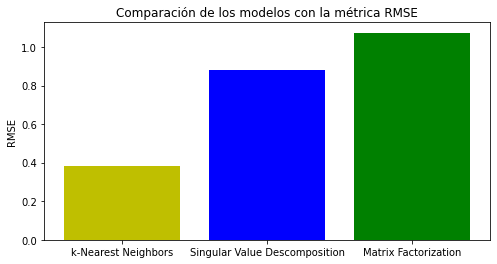

In [28]:
plt.figure(figsize=(8,4))
y = np.array([KNN_RMSE,SVD_RMSE,FM_RMSE])
x = ["k-Nearest Neighbors","Singular Value Descomposition","Matrix Factorization"]
plt.bar(x,y, color=['y', 'b', 'g'])
plt.title("Comparación de los modelos con la métrica RMSE")
plt.ylabel("RMSE")
plt.show()